In [1]:
import os
import glob
import pickle
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gatspy import periodic

import warnings
warnings.filterwarnings('ignore')

# Preparing Dataset From Saha et al. (2017)

In [2]:
saha = pd.read_csv('392work2.tab', sep = '\s{5}', header = None, 
                   names = ['HJD-2400000.0', 'Magnitude', 'Uncertainty in Magnitude', 'Passband'], engine = 'python')
saha.info()
saha.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 4 columns):
HJD-2400000.0               370 non-null float64
Magnitude                   370 non-null float64
Uncertainty in Magnitude    370 non-null float64
Passband                    370 non-null float64
dtypes: float64(4)
memory usage: 11.6 KB


,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
0,56423.664062,27.769,0.030,0.0
1,56423.812500,28.160,0.029,0.0
2,56423.894531,28.089,0.021,0.0
3,56424.718750,27.882,0.024,0.0
4,56424.808594,28.105,0.029,0.0


In [3]:
saha['Passband'] = saha['Passband'].replace({0.0 : 'u', 1.0 : 'g', 2.0 : 'r', 3.0 : 'i', 4.0: 'z'})
saha.head()

,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
0,56423.664062,27.769,0.030,u
1,56423.812500,28.160,0.029,u
2,56423.894531,28.089,0.021,u
3,56424.718750,27.882,0.024,u
4,56424.808594,28.105,0.029,u


In [4]:
saha.tail()

,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
365,57116.839844,21.776,0.015,z
366,57116.851562,21.850,0.017,z
367,57116.863281,21.840,0.019,z
368,57116.890625,21.875,0.012,z
369,57116.906250,21.879,0.012,z


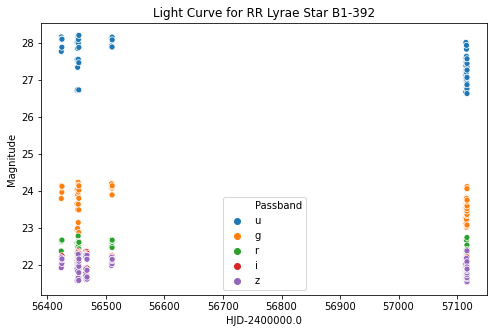

In [5]:
plt.figure(figsize = (8, 5))
plt.title('Light Curve for RR Lyrae Star B1-392')
sns.scatterplot(x = 'HJD-2400000.0', y = 'Magnitude', data = saha, hue = 'Passband');

# Computing the Hybrid Statistic

In [80]:
def phase_dispersion_minimization(times, magnitudes, uncertainties, periods):
    """Implements the formula for calculating the Lafler-Kinman statistic
    using weighted phase dispersion minimization."""
    
    lafler_kinmans = []
    for period in periods:
        
        folded = (times / period) % 1
        ordered = sorted(list(zip(folded, magnitudes, uncertainties)), key = lambda x: x[0])
        unzipped = [list(t) for t in zip(*ordered)]
        measurements, errors = unzipped[1], unzipped[2]
        wrap_measurements = [measurements[-1]] + measurements
        wrap_errors = [errors[-1]] + errors
        
        weights = []
        for i in range(1, len(wrap_errors)):
            weights.append(1 / (wrap_errors[i]**2 + wrap_errors[i - 1]**2))
        
        numerator = []
        for j in range(1, len(wrap_measurements)):
            difference = (wrap_measurements[j] - wrap_measurements[j - 1])**2
            numerator.append(difference * weights[j - 1])
        
        weighted_mean = np.mean(np.array(measurements) * np.array(weights))
        denominator = sum(weights)*sum((np.array(measurements) - weighted_mean)**2)
        lafler_kinman = sum(numerator) / denominator
        lafler_kinmans.append(lafler_kinman)

    return np.array(lafler_kinmans)


def lomb_scargle_analysis(times, magnitudes, uncertainties, min_period = 0.2, max_period = 1.5):
    """Generates the Lomb-Scargle periodogram for a variable star light curve."""
    fit_periods = np.linspace(min_period, max_period, 10000)
    model = periodic.LombScargleFast(fit_period = True)
    model.optimizer.period_range = (min_period, max_period)
    model.fit(times, magnitudes, uncertainties)
    return [fit_periods, model.score(fit_periods)]


def hybrid_statistic(times, magnitudes, uncertainties):
    """Computes the hybrid statistic defined by Saha et al. (2017).
    Then, uses the hybrid statistic to find the best period."""
    periods, pi = lomb_scargle_analysis(times, magnitudes, uncertainties)
    theta = phase_dispersion_minimization(times, magnitudes, uncertainties, periods)
    hybrid_statistic = np.array(2 * pi / theta)
    best_period = periods[np.argmax(hybrid_statistic)]
    return [1 / periods, pi, 2 / theta, hybrid_statistic, best_period]

In [7]:
def filter_data(dataset, passband, **kwargs):
    """Returns light curve data for a specific star in a specific passband."""
    
    filtered = dataset[dataset["Passband"] == passband]
    
    for elem in kwargs.keys():
        try:
            filtered = filtered[filtered[elem.capitalize()] == kwargs.get(elem)]
        except KeyError as e:
            print(f"Dataset does not contain {e.args[0]} column. Attempting to filter based on additional keyword arguments.")
    
    epoch = filtered["HJD-2400000.0"].values
    magnitudes = filtered["Magnitude"].values
    magnitude_errors = filtered["Uncertainty in Magnitude"].values
    return epoch, magnitudes, magnitude_errors


def plot_periodogram(dataset, passband, plot = True, name = "Unknown", **kwargs):
    """Plots Lomb-Scargle, Lafler-Kinman, and hybrid periodograms for a variable star light curve."""
    
    epoch, magnitudes, magnitude_errors = filter_data(dataset, passband, **kwargs)
    frequencies, ls_powers, lk_powers, hybrid_powers, best_period = hybrid_statistic(epoch, magnitudes, magnitude_errors)
    
    if plot:
        
        if 'star' in kwargs.keys():
            name = kwargs.get('star')
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($\Pi$)')
        plt.title(f'Lomb-Scargle Periodogram for {passband} Passband')
        plt.plot(frequencies, ls_powers, label = name)
        plt.legend()
    
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2$ / $\Theta$)')
        plt.title(f'Lafler-Kinman Periodogram for {passband} Passband')
        plt.plot(frequencies, lk_powers, label = name)
        plt.legend()
    
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2\Pi$ / $\Theta$)')
        plt.title(f'Hybrid Periodogram for {passband} Passband')
        plt.plot(frequencies, hybrid_powers, label = name)
        plt.legend();
    
    return [frequencies, ls_powers, lk_powers, hybrid_powers, best_period]

In [8]:
def find_best_period(dataset, plot = True, name = "Unknown", **kwargs):
    """Find the best period by averaging across the results from each passband."""
    
    passbands = dataset["Passband"].unique()
    freqs, ls_powers, lk_powers, hybrid_powers, period = plot_periodogram(dataset, passbands[0], plot = False, **kwargs)
    print('\n')
    
    for passband in passbands[1:]:
        new_results = plot_periodogram(dataset, passband, plot = False, **kwargs)
        ls_powers = ls_powers + new_results[1]
        lk_powers = lk_powers + new_results[2]
        hybrid_powers = hybrid_powers + new_results[3]
        print('\n')
        
    if plot:
        
        if 'star' in kwargs.keys():
            name = kwargs.get('star')
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($\Pi$)')
        plt.title('Lomb-Scargle Periodogram for All Passbands')
        plt.plot(freqs, ls_powers, label = name)
        plt.legend()
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2$ / $\Theta$)')
        plt.title('Lafler-Kinman Periodogram for All Passbands')
        plt.plot(freqs, lk_powers, label = name)
        plt.legend()
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2\Pi$ / $\Theta$)')
        plt.title('Hybrid Periodogram for All Passbands')
        plt.plot(freqs, hybrid_powers, label = name)
        plt.legend();
        
    best_ls_period = 1 / (freqs[np.argmax(ls_powers)])
    best_lk_period = 1 / (freqs[np.argmax(lk_powers)])
    best_hybrid_period = 1 / (freqs[np.argmax(hybrid_powers)])
    
    return [best_ls_period, best_lk_period, best_hybrid_period]

In [9]:
def phase_light_curve(best_period, dataset, passband, name = "Unknown", **kwargs):
    """Phases the variable star light curve based on the best period.
    Then, plots the phased light curve in the specified passband."""
    
    if 'star' in kwargs.keys():
        name = kwargs.get('star')
    
    times, magnitudes, magnitude_errors = filter_data(dataset, passband, **kwargs)
    phases = (times / best_period) % 1
    
    plt.figure()
    plt.title(f'Phased Light Curve in {passband} Passband')
    plt.xlabel('Phase')
    plt.ylabel('Magnitude')
    plt.scatter(phases, magnitudes, label = name)
    plt.errorbar(phases, magnitudes, yerr = magnitude_errors, linestyle = 'None')
    plt.legend();
    
    return phases

Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps

Best Period in g Passband is 0.5016301630163016
True Period is 0.501624 Days


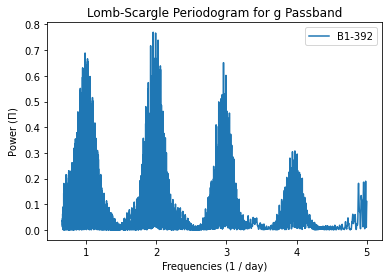

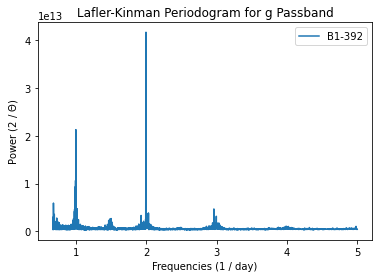

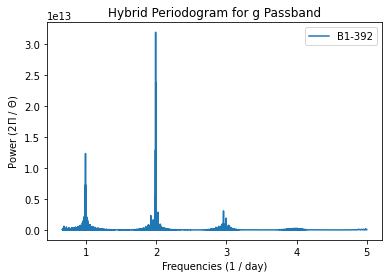

In [10]:
true_period = 0.5016240
g_period = plot_periodogram(saha, 'g', name = 'B1-392')[4];

print("\nBest Period in g Passband is", g_period)
print("True Period is", true_period, "Days")

Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15021 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 

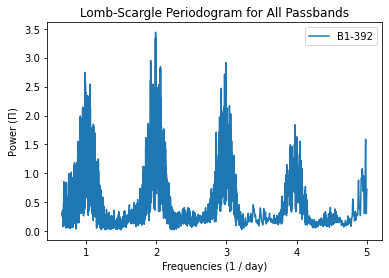

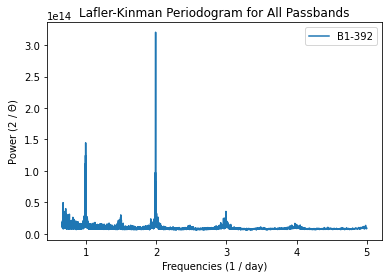

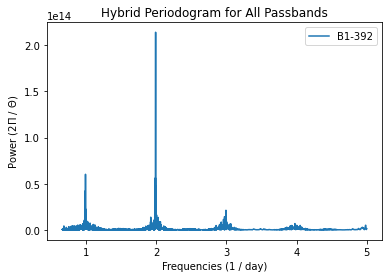

In [11]:
best_period = find_best_period(saha, name = 'B1-392')[2];

print("Best Period is", best_period, "Days")
print("True Period is", true_period, "Days")

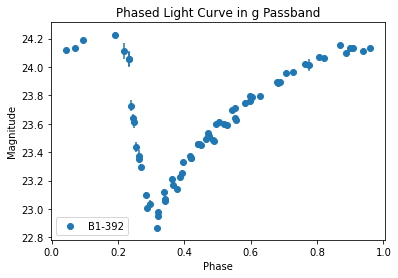

In [12]:
phases = phase_light_curve(best_period, saha, 'g', name = 'B1-392')

# Application to Hubble Space Telescope Data

In [13]:
path = 'J_ApJ_850_137'
photometry_data = glob.glob(os.path.join(path, 'b2*.dat'))

hubble_names_1 = ['Galaxy', 'Star', 'HJD-2400000.0 (F475W)', 'Magnitude (F475W)', 'Uncertainty in Magnitude (F475W)',
                 'HJD-2400000.0 (F814W)', 'Magnitude (F814W)', 'Uncertainty in Magnitude (F814W)']

hubble_photometry = pd.concat((pd.read_csv(file, sep = '\s{1,}', header = None, names = hubble_names_1, engine = 'python') 
                               for file in photometry_data)).sort_values(by = ['Galaxy', 'Star']).dropna()

hubble_photometry['Star'] = hubble_photometry['Star'].str.replace('-', '')
hubble_F475W = hubble_photometry.iloc[:, :5]
hubble_F814W = pd.concat([hubble_photometry.iloc[:, :2], hubble_photometry.iloc[:, 5:]], axis = 1)

hubble_F475W['Passband'] = 'F475W'
hubble_F475W.rename({'HJD-2400000.0 (F475W)' : 'HJD-2400000.0', 'Magnitude (F475W)' : 'Magnitude', 
                    'Uncertainty in Magnitude (F475W)' : 'Uncertainty in Magnitude'}, axis = 1, inplace = True)

hubble_F814W['Passband'] = 'F814W'
hubble_F814W.rename({'HJD-2400000.0 (F814W)' : 'HJD-2400000.0', 'Magnitude (F814W)' : 'Magnitude', 
                    'Uncertainty in Magnitude (F814W)' : 'Uncertainty in Magnitude'}, axis = 1, inplace = True)

hubble_photometry = pd.concat([hubble_F475W, hubble_F814W], axis = 0).sort_values(by = ['Galaxy', 'Star'])
hubble_photometry.to_csv('hubble.csv', index = False)
hubble_photometry.head()

,Galaxy,Star,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
0,AndI,V001,57266.425781,25.254,0.089,F475W
1,AndI,V001,57266.500000,25.523,0.056,F475W
2,AndI,V001,57266.691406,25.801,0.041,F475W
3,AndI,V001,57266.765625,25.917,0.064,F475W
4,AndI,V001,57267.417969,25.175,0.036,F475W


In [14]:
pulsation_data = glob.glob(os.path.join(path, 'd4*.dat'))

hubble_names_2 = ['Galaxy', 'Star', 'RA (Hour)', 'RA (Minutes)', 'RA (Seconds)', 'Dec (Degrees)', 'Dec (Minutes)', 
                  'Dec (Seconds)', 'Period (Days)', 'Magnitude (F475W)', 'Amplitude (F475W)', 'Magnitude (F814W)', 
                  'Amplitude (F814W)', 'Magnitude (B-Band)', 'Amplitude (B-Band)', 'Magnitude (V-Band)', 'Amplitude (V-Band)', 
                  'Magnitude (Ic-Band)', 'Amplitude (Ic-Band)', 'Variable Type', 'Camera']

hubble_pulsation = pd.concat((pd.read_csv(file, sep = '\s{1,}', header = None, names = hubble_names_2, engine = 'python') 
                              for file in pulsation_data)).sort_values(by = ['Galaxy', 'Star'])

hubble_pulsation['Star'] = hubble_pulsation['Star'].str.replace('-', '')
hubble_pulsation.head()

,Galaxy,Star,RA (Hour),RA (Minutes),RA (Seconds),Dec (Degrees),Dec (Minutes),Dec (Seconds),Period (Days),Magnitude (F475W),...,Magnitude (F814W),Amplitude (F814W),Magnitude (B-Band),Amplitude (B-Band),Magnitude (V-Band),Amplitude (V-Band),Magnitude (Ic-Band),Amplitude (Ic-Band),Variable Type,Camera
0,AndI,V001,0,45,9.233,37,58,47.19,0.569,25.532,...,24.692,0.574,25.657,1.137,25.266,0.915,24.677,0.580,RRab,WFC3
1,AndI,V002,0,45,9.646,37,59,48.86,0.567,25.505,...,24.737,0.358,25.613,0.669,25.251,0.436,24.719,0.360,RRab,WFC3
2,AndI,V003,0,45,9.819,37,59,32.31,0.296,25.329,...,24.831,0.091,25.398,0.392,25.159,0.207,24.819,0.097,RRc,WFC3
3,AndI,V004,0,45,10.116,37,58,44.43,0.598,25.322,...,24.607,0.699,25.415,1.605,25.103,0.949,24.599,0.669,RRab,WFC3
4,AndI,V005,0,45,10.429,37,58,56.47,0.585,25.557,...,24.733,0.608,25.680,0.864,25.276,0.660,24.722,0.576,RRab,WFC3


In [15]:
hubble_periods = hubble_pulsation[['Galaxy', 'Star', 'Period (Days)']]
hubble_periods.info()

hubble_periods.to_csv('hubble_periods.csv', index = False)
hubble_periods.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 0 to 89
Data columns (total 3 columns):
Galaxy           895 non-null object
Star             895 non-null object
Period (Days)    895 non-null float64
dtypes: float64(1), object(2)
memory usage: 28.0+ KB


,Galaxy,Star,Period (Days)
0,AndI,V001,0.569
1,AndI,V002,0.567
2,AndI,V003,0.296
3,AndI,V004,0.598
4,AndI,V005,0.585


Finding optimal frequency:
 - Estimated peak width = 1.18
 - Using 5 steps per peak; omega_step = 0.237
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 117 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps

Best Period in F475W Passband is 0.5637763776377638 Days


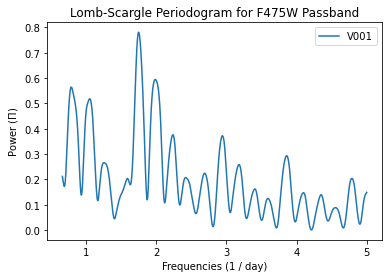

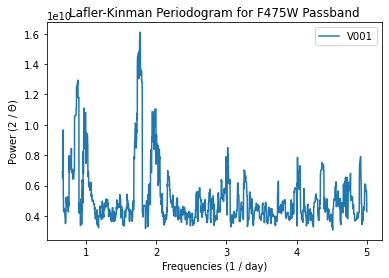

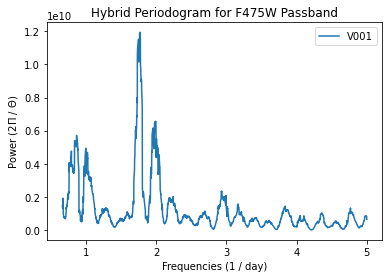

In [16]:
best_period_AndI_V001_F475W = plot_periodogram(hubble_photometry, 'F475W', star = 'V001', galaxy = 'AndI')[4];
print(f"\nBest Period in F475W Passband is {best_period_AndI_V001_F475W} Days")

Finding optimal frequency:
 - Estimated peak width = 1.18
 - Using 5 steps per peak; omega_step = 0.237
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 117 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 1.19
 - Using 5 steps per peak; omega_step = 0.238
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 116 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps



Best Period is 0.5676767676767677 Days


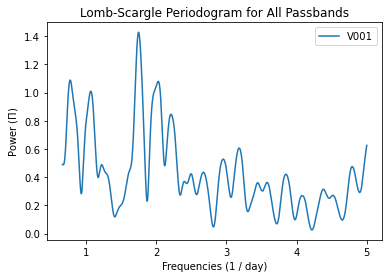

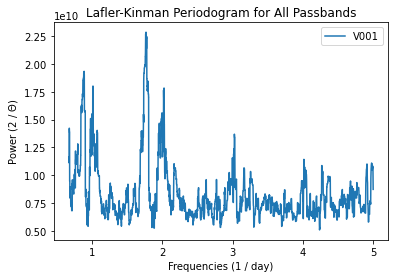

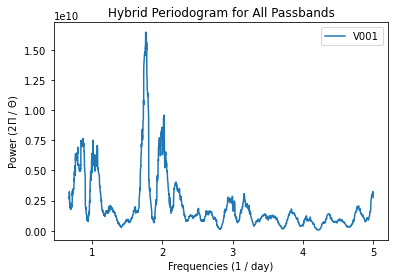

In [17]:
best_period_AndI_V001 = find_best_period(hubble_photometry, star = 'V001', galaxy = 'AndI')[2];
print(f"\nBest Period is {best_period_AndI_V001} Days")

In [18]:
hubble_best_periods = np.array(pickle.load(open("hubble_periods.pkl", "rb")))[:, 2:].T[0]
hubble_periods['Best Period (Days)'] = hubble_best_periods
hubble_periods.head()

,Galaxy,Star,Period (Days),Best Period (Days)
0,AndI,V001,0.569,0.567677
1,AndI,V002,0.567,0.569237
2,AndI,V003,0.296,0.293479
3,AndI,V004,0.598,0.598360
4,AndI,V005,0.585,0.576128


In [19]:
np.average(np.abs(hubble_periods.iloc[:, 3] - hubble_periods.iloc[:, 2]))

0.024644598649809116

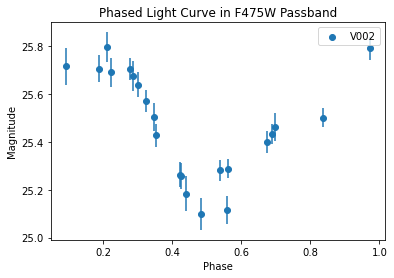

In [20]:
AndI_V001_phases = phase_light_curve(hubble_periods.iloc[1, 3], hubble_photometry, 'F475W', star = 'V002', galaxy = 'AndI')

# Application to Sculptor Data

In [21]:
sculptor_path_1 = os.path.join('J_MNRAS_462_4349', 'table4.dat')

sculptor_names_1 = ['Star', 'Name 1', 'Name 2', 'RA (Hour)', 'RA (Minutes)', 'RA (Seconds)', 'Dec (Degrees)', 'Dec (Minutes)', 
                    'Dec (Seconds)', 'Period (Days)', 'Uncertainty Flag on Period', 'Mean Magnitude (B)', 'Mean Magnitude (V)', 
                    'Mean Magnitude (I)', 'Amplitude (B)', 'Amplitude (V)', 'Amplitude (I)', 'Quality Flag 1', 'Quality Flag 2',
                    'Variable Type']

sculptor_pulsation = pd.read_csv(sculptor_path_1, sep = '\s{1,}', header = None, names = sculptor_names_1, engine = 'python', 
                                 usecols = [i for i in range(21)])

sculptor_pulsation = sculptor_pulsation.replace({"--" : np.nan, "----" : np.nan, "-----" : np.nan})
sculptor_pulsation.head()

,Star,Name 1,Name 2,RA (Hour),RA (Minutes),RA (Seconds),Dec (Degrees),Dec (Minutes),Dec (Seconds),Period (Days),Uncertainty Flag on Period,Mean Magnitude (B),Mean Magnitude (V),Mean Magnitude (I),Amplitude (B),Amplitude (V),Amplitude (I),Quality Flag 1,Quality Flag 2,Variable Type
0,scl-CEMV001,V461,NaN,0,55,21.02,-33,41,1.5,0.420876,::,20.150,19.830,19.460,0.900,0.630,0.000,1,0,RRab
1,scl-CEMV002,NaN,NaN,0,56,9.15,-33,29,20.1,0.305970,NaN,20.326,20.163,19.840,0.298,0.254,0.168,0,1,RRc
2,scl-CEMV005,NaN,NaN,0,56,38.94,-33,24,32.4,0.309746,NaN,20.260,20.086,19.778,0.494,0.359,0.165,0,1,RRc
3,scl-CEMV006,NaN,NaN,0,56,48.78,-33,31,16.3,0.332111,NaN,20.333,20.117,19.738,0.568,0.479,0.401,0,1,RRc
4,scl-CEMV008,NaN,NaN,0,57,4.83,-33,45,20.6,0.281318,NaN,20.357,20.047,19.570,0.881,0.576,0.485,2,0,RRc


In [105]:
sculptor_path_2 = os.path.join('J_MNRAS_462_4349', 'table2.dat')

sculptor_names_2 = ['Star', 'HJD-2400000.0 (B)', 'Magnitude (B)', 'Uncertainty in Magnitude (B)',
                  'HJD-2400000.0 (V)', 'Magnitude (V)', 'Uncertainty in Magnitude (V)', 
                  'HJD-2400000.0 (I)', 'Magnitude (I)', 'Uncertainty in Magnitude (I)']

sculptor_photometry = pd.read_csv(sculptor_path_2, sep = '\s{1,}', header = None, names = sculptor_names_2, engine = 'python')

sculptor_B = sculptor_photometry.iloc[:, :4]
sculptor_V = pd.concat([sculptor_photometry.iloc[:, :1], sculptor_photometry.iloc[:, 4:7]], axis = 1)
sculptor_I = pd.concat([sculptor_photometry.iloc[:, :1], sculptor_photometry.iloc[:, 7:]], axis = 1)

sculptor_B['Passband'] = 'B'
sculptor_B.rename({'HJD-2400000.0 (B)' : 'HJD-2400000.0', 'Magnitude (B)' : 'Magnitude', 
                   'Uncertainty in Magnitude (B)' : 'Uncertainty in Magnitude'}, axis = 1, inplace = True)

sculptor_V['Passband'] = 'V'
sculptor_V.rename({'HJD-2400000.0 (V)' : 'HJD-2400000.0', 'Magnitude (V)' : 'Magnitude', 
                   'Uncertainty in Magnitude (V)' : 'Uncertainty in Magnitude'}, axis = 1, inplace = True)

sculptor_I['Passband'] = 'I'
sculptor_I.rename({'HJD-2400000.0 (I)' : 'HJD-2400000.0', 'Magnitude (I)' : 'Magnitude', 
                   'Uncertainty in Magnitude (I)' : 'Uncertainty in Magnitude'}, axis = 1, inplace = True)

sculptor_photometry = pd.concat([sculptor_B, sculptor_V, sculptor_I], axis = 0)
sculptor_photometry = sculptor_photometry.replace("---", np.nan).dropna()
sculptor_photometry = sculptor_photometry.astype({"HJD-2400000.0" : 'float64', "Magnitude" : 'float64', 
                                                  "Uncertainty in Magnitude" : 'float64'})

sculptor_photometry = sculptor_photometry[sculptor_photometry["Star"].isin(sculptor_pulsation["Star"].unique())]

sculptor_photometry.to_csv('sculptor.csv', index = False)
sculptor_photometry.head()

,Star,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
0,scl-CEMV001,54734.6147,19.636,0.011,B
1,scl-CEMV001,54734.6561,19.809,0.017,B
2,scl-CEMV001,54734.7185,20.070,0.026,B
3,scl-CEMV001,54734.7516,20.314,0.311,B
4,scl-CEMV001,54734.7742,20.220,0.010,B


In [106]:
sculptor_periods = sculptor_pulsation[["Star", "Period (Days)"]]
sculptor_periods.info()

sculptor_periods.to_csv('sculptor_periods.csv', index = False)
sculptor_periods.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 2 columns):
Star             536 non-null object
Period (Days)    536 non-null float64
dtypes: float64(1), object(1)
memory usage: 8.5+ KB


,Star,Period (Days)
0,scl-CEMV001,0.420876
1,scl-CEMV002,0.305970
2,scl-CEMV005,0.309746
3,scl-CEMV006,0.332111
4,scl-CEMV008,0.281318


Finding optimal frequency:
 - Estimated peak width = 0.00343
 - Using 5 steps per peak; omega_step = 0.000685
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 39742 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps

Best Period in V Passband is 0.4236223622362236 Days


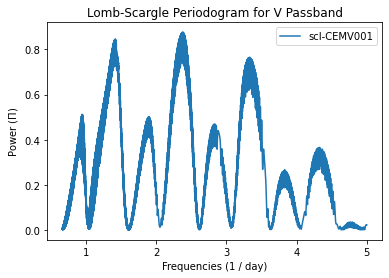

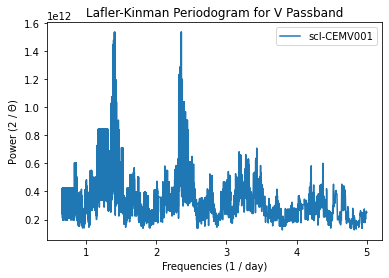

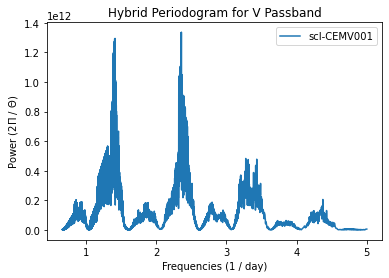

In [108]:
best_period_V001_V = plot_periodogram(sculptor_photometry, 'V', star = 'scl-CEMV001')[4];
print(f"\nBest Period in V Passband is {best_period_V001_V} Days")

Finding optimal frequency:
 - Estimated peak width = 2.75
 - Using 5 steps per peak; omega_step = 0.55
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 51 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00343
 - Using 5 steps per peak; omega_step = 0.000685
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 39742 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps



Best Period is 0.711081108110811 Days


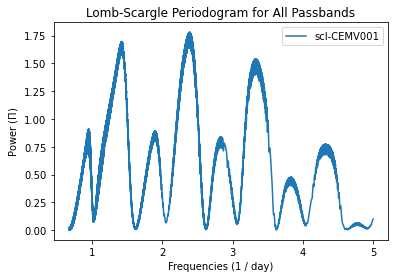

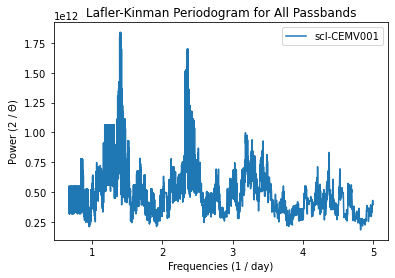

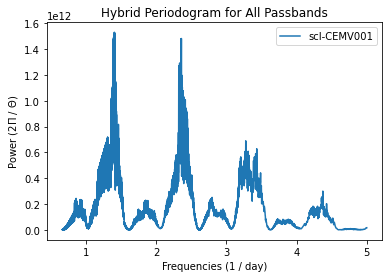

In [101]:
best_period_V001 = find_best_period(sculptor_photometry, star = 'scl-CEMV001')[2];
print(f"\nBest Period is {best_period_V001} Days")

In [102]:
sculptor_best_periods = np.array(pickle.load(open("sculptor_periods.pkl", "rb")))[:, 2:].T[0]
sculptor_periods['Best Period (Days)'] = sculptor_best_periods
sculptor_periods.head()

,Star,Period (Days),Best Period (Days)
0,scl-CEMV001,0.420876,0.711081
1,scl-CEMV002,0.305970,0.306741
2,scl-CEMV005,0.309746,0.309731
3,scl-CEMV006,0.332111,0.938604
4,scl-CEMV008,0.281318,0.593809


In [103]:
np.average(np.abs(sculptor_periods.iloc[:, 2] - sculptor_periods.iloc[:, 1]))

0.3738230513574603

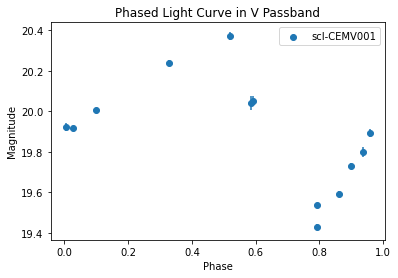

In [104]:
V001_phases = phase_light_curve(sculptor_periods.iloc[0, 2], sculptor_photometry, 'V', star = 'scl-CEMV001')

# Investigating the Effects of Sparsity and Noise

In [26]:
def simulate_sparsity_and_noise(dataset, passband, sparsity = 1.0, signal_to_noise = 0, **kwargs):
    """Simulates sparsity and noise in the light curve data of a specific star in a specific passband."""
    
    times, magnitudes, errors = filter_data(dataset, passband, **kwargs)
    simulated = pd.DataFrame({"HJD-2400000.0" : times, "Magnitude" : magnitudes, 
                              "Uncertainty in Magnitude" : errors, "Passband" : passband})
    
    if sparsity != 1.0:
        simulated = simulated.sample(frac = sparsity)
    
    if signal_to_noise != 0:
        simulated["Uncertainty in Magnitude"] = 2.5 * np.log10(1 + 1 / signal_to_noise)
        noise = [np.random.normal(0, error) for error in simulated["Uncertainty in Magnitude"].values]
        simulated["Magnitude"] = simulated["Magnitude"] + noise
    
    return simulated


def simulate_best_period(dataset, sparsity = 1.0, signal_to_noise = 0, plot = False, name = "Unknown", lc = False, **kwargs):
    """Simulates sparsity and noise in the light curve data of a specific star.
    Then, determines the effect on the calculation of the best period."""
    
    passbands = dataset["Passband"].unique()
    initial = simulate_sparsity_and_noise(dataset, passbands[0], sparsity, signal_to_noise, **kwargs)
    
    for passband in passbands[1:]:
        
        new_data = simulate_sparsity_and_noise(dataset, passband, sparsity, signal_to_noise, **kwargs)
        initial = pd.concat([initial, new_data], axis = 0)
    
    best_periods = find_best_period(initial, plot = plot, name = name, **kwargs)
    
    if lc:
        phases = phase_light_curve(best_periods[2], initial, passbands[1], name = name, **kwargs)
        
    return best_periods

In [27]:
sparsities = np.array([1.0, 0.5, 0.25, 0.125])
sn_ratios = np.array([1, 10, 100, 1000])
combinations = itertools.product(sparsities, sn_ratios)

# sparse_periods = []
# for combo in combinations:
#     sparse_periods.append(simulate_best_period(saha, combo[0], combo[1]))
# pickle.dump(np.array(sparse_periods), open("sparse_periods.pkl", "wb"))

best_periods = pickle.load(open("sparse_periods.pkl", "rb"))

In [28]:
parameters = pd.DataFrame(list(combinations), columns = ["Sparsity", "Signal-to-Noise"])
results = pd.DataFrame(best_periods, columns = ["Lomb-Scargle", "Lafler-Kinman", "Hybrid Method"])
results_table = pd.concat([parameters, results], axis = 1)
results_table

,Sparsity,Signal-to-Noise,Lomb-Scargle,Lafler-Kinman,Hybrid Method
0,1.000,1,0.501240,0.948875,0.501240
1,1.000,10,0.501630,0.502020,0.502020
2,1.000,100,0.501630,0.501630,0.501630
3,1.000,1000,0.501630,0.501630,0.501630
4,0.500,1,0.549345,1.099560,0.529193
5,0.500,10,0.520092,0.501630,0.501630
6,0.500,100,0.501630,0.501240,0.501630
7,0.500,1000,0.501630,0.501630,0.501630
8,0.250,1,0.836414,0.727853,0.906361
9,0.250,10,0.501240,0.501630,0.501630


In [29]:
results_table.pivot(index = "Sparsity", columns = "Signal-to-Noise")

Lomb-Scargle                               Lafler-Kinman  \
Signal-to-Noise         1         10        100       1000          1      
Sparsity                                                                   
0.125               1.257136  0.501240  0.342364  0.501630      0.781678   
0.250               0.836414  0.501240  0.501630  0.341454      0.727853   
0.500               0.549345  0.520092  0.501630  0.501630      1.099560   
1.000               0.501240  0.501630  0.501630  0.501630      0.948875   

                                            Hybrid Method                     \
Signal-to-Noise     10        100      1000          1        10        100    
Sparsity                                                                       
0.125            0.50124  0.976828  0.50163      0.472377  1.00309  1.023372   
0.250            0.50163  0.501630  0.50163      0.906361  0.50163  0.501630   
0.500            0.50163  0.501240  0.50163      0.529193  0.50163  0.501630   
1.000            0.50202  0.501630  0.50163      0.501240  0.50202  0.501630   

                          
Signal-to-Noise     1000  
Sparsity                  
0.125            0.50163  
0.250            0.50163  
0.500            0.50163  
1.000            0.50163

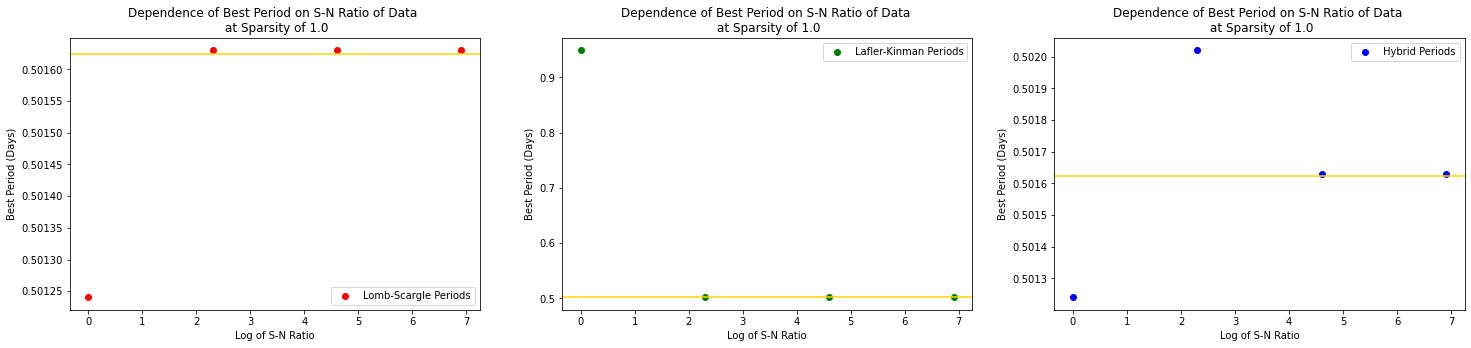

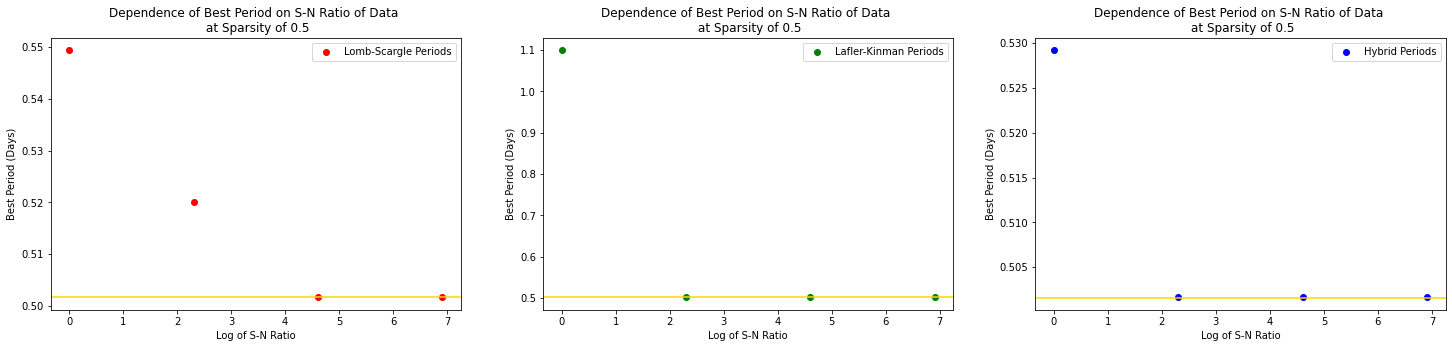

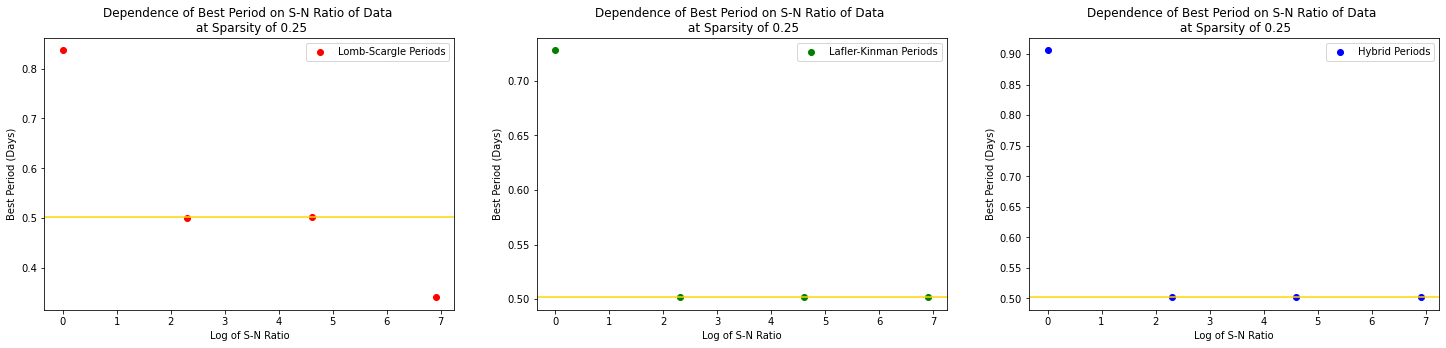

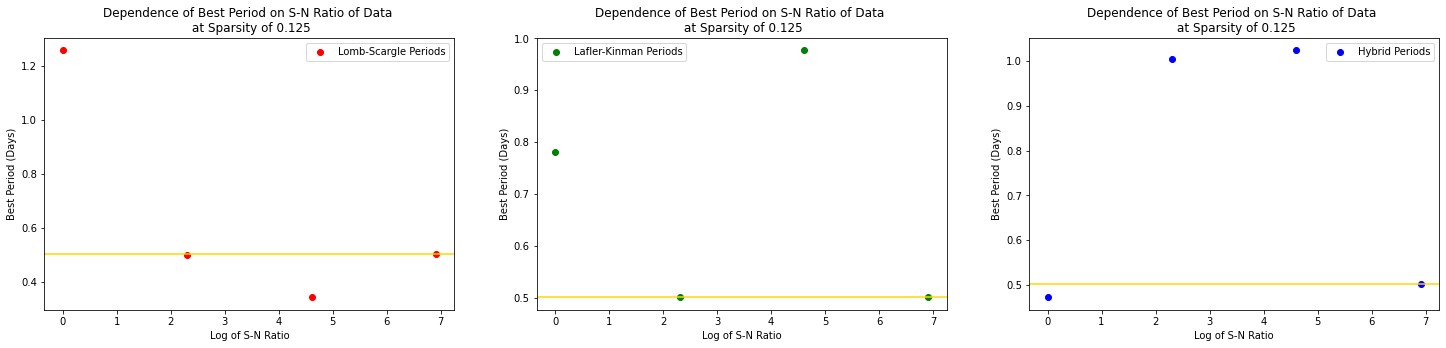

In [30]:
for sparsity in sparsities:
    filtered_results = results_table[results_table["Sparsity"] == sparsity]
    fig, axs = plt.subplots(1, 3, figsize = (25, 5))
    for ax in axs:
        ax.set_title(f'Dependence of Best Period on S-N Ratio of Data \n at Sparsity of {sparsity}')
        ax.set_xlabel('Log of S-N Ratio')
        ax.set_ylabel('Best Period (Days)')
    axs[0].scatter(np.log(sn_ratios), filtered_results["Lomb-Scargle"], label = 'Lomb-Scargle Periods', color = 'r')
    axs[1].scatter(np.log(sn_ratios), filtered_results["Lafler-Kinman"], label = 'Lafler-Kinman Periods', color = 'g')
    axs[2].scatter(np.log(sn_ratios), filtered_results["Hybrid Method"], label = 'Hybrid Periods', color = 'b')
    for ax in axs:
        ax.axhline(y = 0.501624, color = 'gold', linestyle = '-')
        ax.legend();

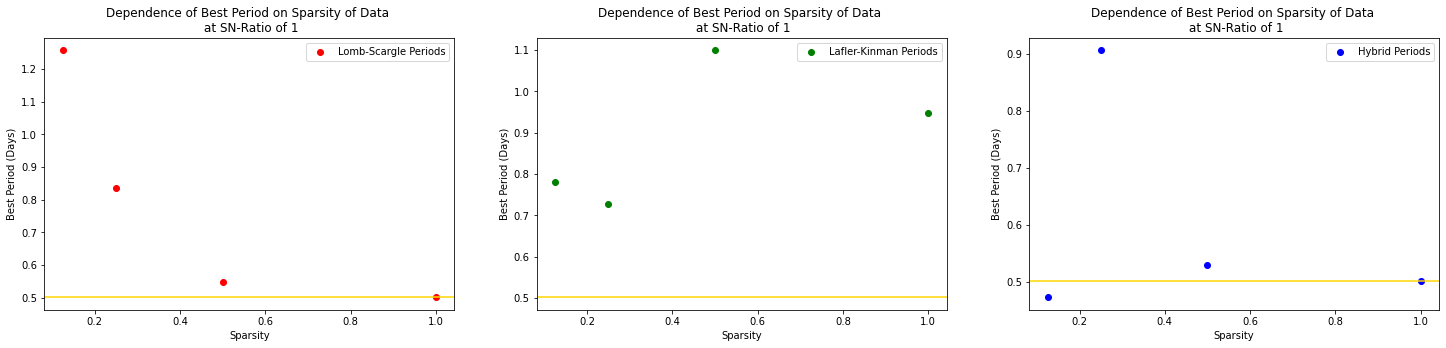

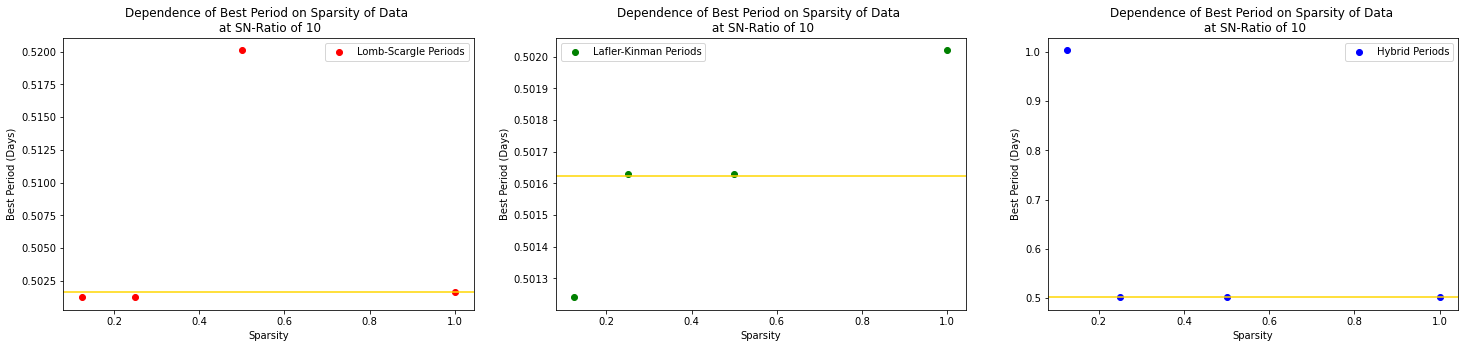

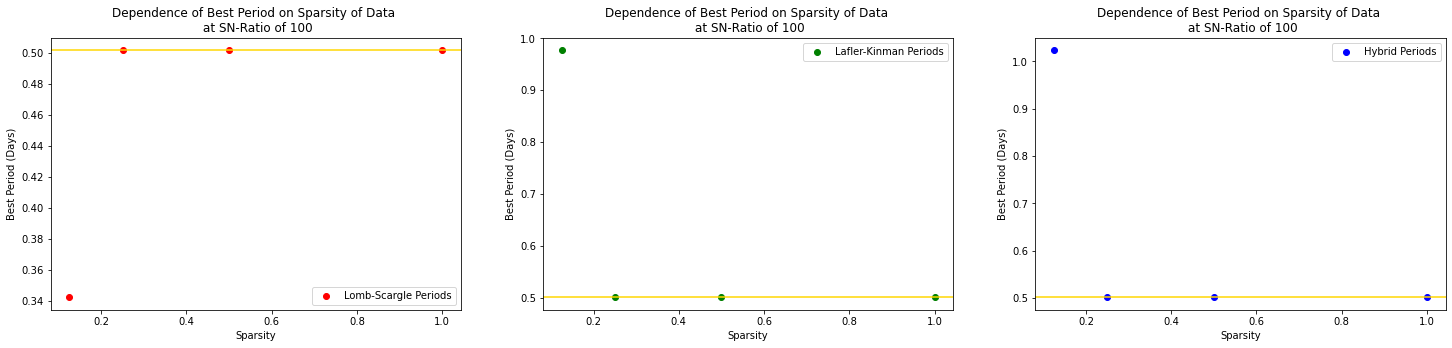

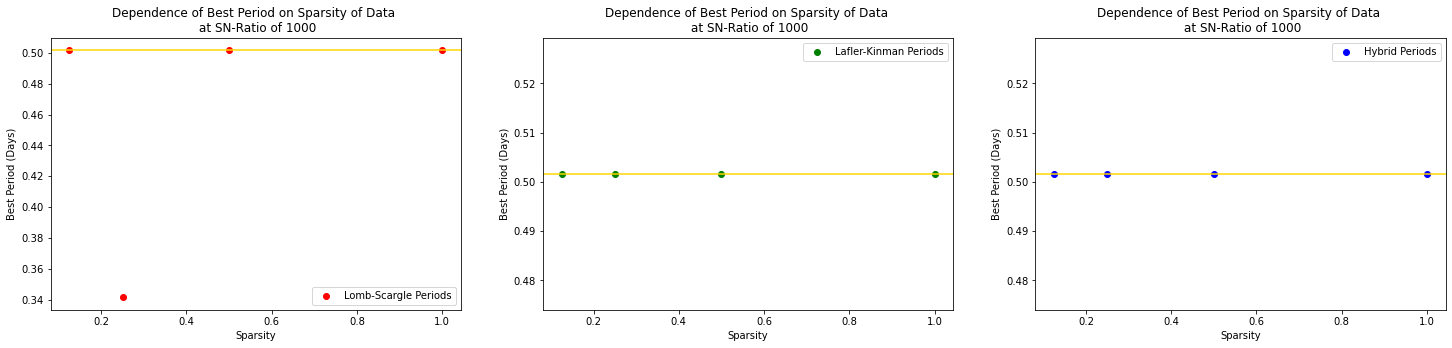

In [31]:
for sn in sn_ratios:
    filtered_results = results_table[results_table["Signal-to-Noise"] == sn]
    fig, axs = plt.subplots(1, 3, figsize = (25, 5))
    for ax in axs:
        ax.set_title(f'Dependence of Best Period on Sparsity of Data \n at SN-Ratio of {sn}')
        ax.set_xlabel('Sparsity')
        ax.set_ylabel('Best Period (Days)')
    axs[0].scatter(sparsities, filtered_results["Lomb-Scargle"], label = 'Lomb-Scargle Periods', color = 'r')
    axs[1].scatter(sparsities, filtered_results["Lafler-Kinman"], label = 'Lafler-Kinman Periods', color = 'g')
    axs[2].scatter(sparsities, filtered_results["Hybrid Method"], label = 'Hybrid Periods', color = 'b')
    for ax in axs:
        ax.axhline(y = 0.501624, color = 'gold', linestyle = '-')
        ax.legend();

Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15021 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00907
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15019 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 -

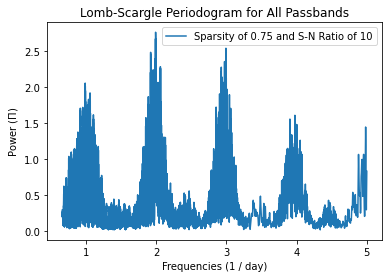

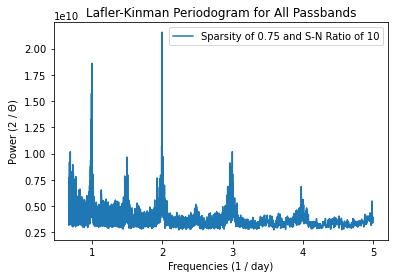

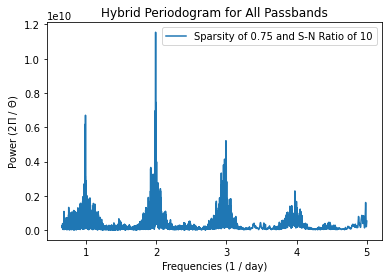

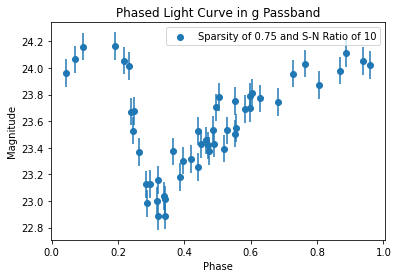

In [32]:
dense_noisy = simulate_best_period(saha, sparsity = 0.75, signal_to_noise = 10, plot = True, 
                                   name = "Sparsity of 0.75 and S-N Ratio of 10", lc = True)

Finding optimal frequency:
 - Estimated peak width = 0.00945
 - Using 5 steps per peak; omega_step = 0.00189
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 14415 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15020 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00943
 - Using 5 steps per peak; omega_step = 0.00189
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 14435 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00908
 - Using 5 steps per peak; omega_step = 0.00182
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 14992 steps
Zooming-in on 5 candidate peaks:
 - 

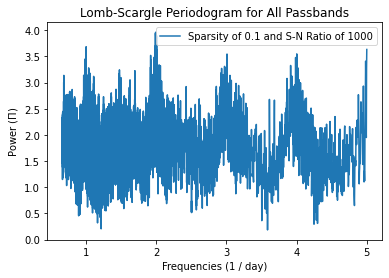

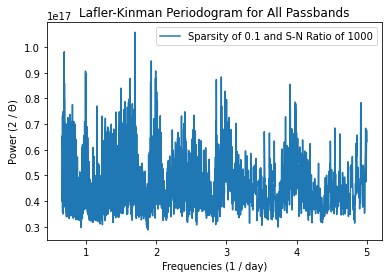

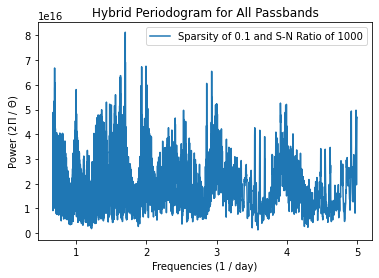

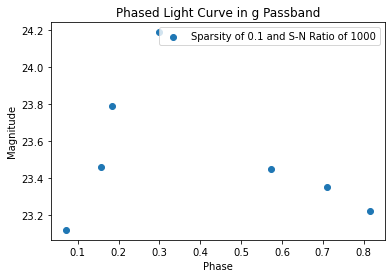

In [33]:
sparse_signal = simulate_best_period(saha, sparsity = 0.1, signal_to_noise = 1000, plot = True, 
                                     name = "Sparsity of 0.1 and S-N Ratio of 1000", lc = True)